# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

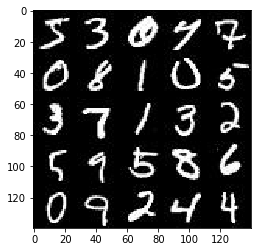

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

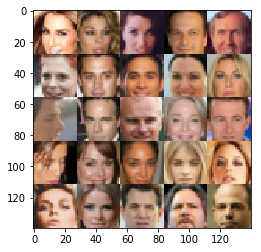

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [19]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    training = True
    #print(images.get_shape())
    with tf.variable_scope('discriminator', reuse=reuse):
        # input: 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape())
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, rate=0.1)
        #print(x2.get_shape())
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding='same',
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01))
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate=0.1)
        #print(x3.get_shape())
        # 7x7x256
        
        flat = tf.reshape(x3, (-1, 7*7*256))
#         flat = tf.reshape(x2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #print(z.get_shape())
    # https://discussions.udacity.com/t/generator-output-shape/247548/4
    reuse = not is_train
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=reuse):
        # input z: 100
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        #x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #print(x1.get_shape())
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.get_shape())
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.get_shape())
        # 28x28x128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        #print(x3.get_shape())
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        #print(logits.get_shape())
        # 28x28x5
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # def generator(z, out_channel_dim, is_train=True)
    # def discriminator(images, reuse=False)
    is_train = True
    smooth = 0.1
    
    input_fake = generator(input_z, out_channel_dim, is_train)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(input_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                        labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    
    # MNIST: (60000, 28, 28, 1)
    # CelebA: (202599, 28, 28, 3)
    input_real, input_z, learning_rate_p = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_p, beta1)
    
    print_every = 10
    show_every = 100
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     learning_rate_p: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     learning_rate_p: learning_rate})
                # Optimize the generator multiple times to learn quickly
                # https://discussions.udacity.com/t/why-does-multiple-iterations-of-generator-model-optimization-per-batch-work-better/248392
#                 _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
#                                                      input_z: batch_z,
#                                                      learning_rate_p: learning_rate})
#                 _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,
#                                                      input_z: batch_z,
#                                                      learning_rate_p: learning_rate})
              
                
                # print losses
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, 
                                                input_z: batch_z, 
                                                learning_rate_p: learning_rate})
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                                input_z: batch_z,
                                                learning_rate_p: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # print the generator output every 100 batches
                if steps % show_every == 0:
                    # def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
        #saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1747 Generator Loss: 5.4027
Epoch 1/2... Discriminator Loss: 1.9549 Generator Loss: 0.7962
Epoch 1/2... Discriminator Loss: 4.1971 Generator Loss: 6.6300
Epoch 1/2... Discriminator Loss: 0.7639 Generator Loss: 2.0987
Epoch 1/2... Discriminator Loss: 0.6518 Generator Loss: 2.1163
Epoch 1/2... Discriminator Loss: 1.4802 Generator Loss: 0.9539
Epoch 1/2... Discriminator Loss: 2.8273 Generator Loss: 0.1734
Epoch 1/2... Discriminator Loss: 0.9818 Generator Loss: 1.9821
Epoch 1/2... Discriminator Loss: 0.9674 Generator Loss: 1.7501
Epoch 1/2... Discriminator Loss: 2.2418 Generator Loss: 2.6182


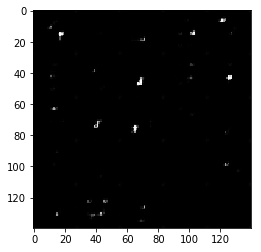

Epoch 1/2... Discriminator Loss: 1.4758 Generator Loss: 2.1759
Epoch 1/2... Discriminator Loss: 1.1943 Generator Loss: 1.0205
Epoch 1/2... Discriminator Loss: 2.3276 Generator Loss: 2.8830
Epoch 1/2... Discriminator Loss: 1.2588 Generator Loss: 0.9704
Epoch 1/2... Discriminator Loss: 1.1566 Generator Loss: 1.4056
Epoch 1/2... Discriminator Loss: 1.3299 Generator Loss: 1.6720
Epoch 1/2... Discriminator Loss: 1.6354 Generator Loss: 0.5240
Epoch 1/2... Discriminator Loss: 1.0913 Generator Loss: 1.6978
Epoch 1/2... Discriminator Loss: 1.7110 Generator Loss: 0.4596
Epoch 1/2... Discriminator Loss: 2.0060 Generator Loss: 2.0729


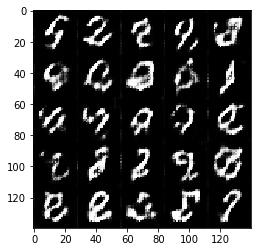

Epoch 1/2... Discriminator Loss: 1.1769 Generator Loss: 0.9701
Epoch 1/2... Discriminator Loss: 1.3559 Generator Loss: 1.1841
Epoch 1/2... Discriminator Loss: 2.0567 Generator Loss: 0.2498
Epoch 1/2... Discriminator Loss: 1.2456 Generator Loss: 0.7230
Epoch 1/2... Discriminator Loss: 1.4696 Generator Loss: 0.5868
Epoch 1/2... Discriminator Loss: 1.1365 Generator Loss: 1.0186
Epoch 1/2... Discriminator Loss: 1.4582 Generator Loss: 1.0056
Epoch 1/2... Discriminator Loss: 1.3266 Generator Loss: 0.7895
Epoch 1/2... Discriminator Loss: 1.5878 Generator Loss: 0.4941
Epoch 1/2... Discriminator Loss: 1.4461 Generator Loss: 0.5102


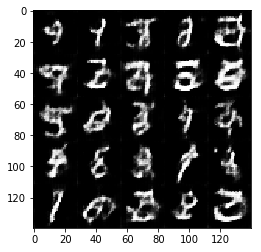

Epoch 1/2... Discriminator Loss: 1.8258 Generator Loss: 0.3747
Epoch 1/2... Discriminator Loss: 1.1381 Generator Loss: 1.2505
Epoch 1/2... Discriminator Loss: 1.1985 Generator Loss: 1.4889
Epoch 1/2... Discriminator Loss: 1.3570 Generator Loss: 1.5352
Epoch 1/2... Discriminator Loss: 1.4261 Generator Loss: 1.9217
Epoch 1/2... Discriminator Loss: 1.2882 Generator Loss: 0.8271
Epoch 1/2... Discriminator Loss: 1.2703 Generator Loss: 0.7285
Epoch 1/2... Discriminator Loss: 1.2115 Generator Loss: 0.8616
Epoch 1/2... Discriminator Loss: 1.2680 Generator Loss: 1.1268
Epoch 1/2... Discriminator Loss: 1.4238 Generator Loss: 0.5224


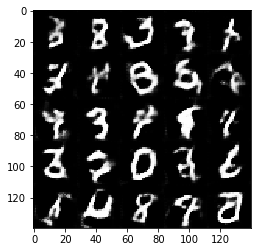

Epoch 1/2... Discriminator Loss: 1.6261 Generator Loss: 2.5175
Epoch 1/2... Discriminator Loss: 1.4952 Generator Loss: 0.5611
Epoch 1/2... Discriminator Loss: 1.5127 Generator Loss: 2.0493
Epoch 1/2... Discriminator Loss: 1.3485 Generator Loss: 0.6596
Epoch 1/2... Discriminator Loss: 1.3460 Generator Loss: 1.3255
Epoch 1/2... Discriminator Loss: 1.4811 Generator Loss: 0.5121
Epoch 2/2... Discriminator Loss: 1.3914 Generator Loss: 0.6585
Epoch 2/2... Discriminator Loss: 1.2602 Generator Loss: 1.3091
Epoch 2/2... Discriminator Loss: 1.1959 Generator Loss: 1.1985
Epoch 2/2... Discriminator Loss: 1.3422 Generator Loss: 0.6714


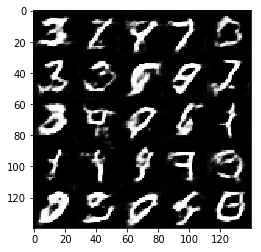

Epoch 2/2... Discriminator Loss: 1.3671 Generator Loss: 0.8105
Epoch 2/2... Discriminator Loss: 1.5779 Generator Loss: 0.5025
Epoch 2/2... Discriminator Loss: 1.3839 Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 1.7309 Generator Loss: 0.3767
Epoch 2/2... Discriminator Loss: 1.2175 Generator Loss: 1.0627
Epoch 2/2... Discriminator Loss: 1.3037 Generator Loss: 1.7004
Epoch 2/2... Discriminator Loss: 1.3380 Generator Loss: 1.1690
Epoch 2/2... Discriminator Loss: 1.3483 Generator Loss: 1.3727
Epoch 2/2... Discriminator Loss: 1.3934 Generator Loss: 0.7962
Epoch 2/2... Discriminator Loss: 1.3112 Generator Loss: 0.7229


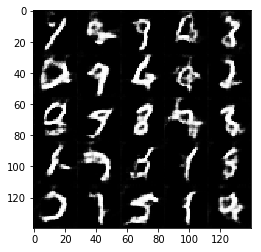

Epoch 2/2... Discriminator Loss: 1.3075 Generator Loss: 0.9966
Epoch 2/2... Discriminator Loss: 1.2459 Generator Loss: 0.7481
Epoch 2/2... Discriminator Loss: 1.3078 Generator Loss: 1.1626
Epoch 2/2... Discriminator Loss: 1.3854 Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 1.4788 Generator Loss: 1.6367
Epoch 2/2... Discriminator Loss: 1.3814 Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.3331 Generator Loss: 1.2127
Epoch 2/2... Discriminator Loss: 1.3303 Generator Loss: 1.2744
Epoch 2/2... Discriminator Loss: 1.3407 Generator Loss: 1.7185
Epoch 2/2... Discriminator Loss: 1.6777 Generator Loss: 0.3723


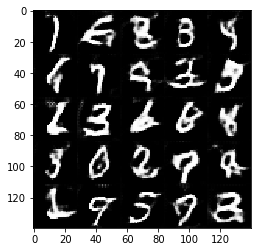

Epoch 2/2... Discriminator Loss: 1.3082 Generator Loss: 0.6968
Epoch 2/2... Discriminator Loss: 1.5278 Generator Loss: 1.8471
Epoch 2/2... Discriminator Loss: 1.4454 Generator Loss: 1.4827
Epoch 2/2... Discriminator Loss: 1.2903 Generator Loss: 1.5351
Epoch 2/2... Discriminator Loss: 1.3176 Generator Loss: 0.6448
Epoch 2/2... Discriminator Loss: 1.1995 Generator Loss: 1.2166
Epoch 2/2... Discriminator Loss: 1.3376 Generator Loss: 0.7047
Epoch 2/2... Discriminator Loss: 1.2454 Generator Loss: 0.9205
Epoch 2/2... Discriminator Loss: 1.2711 Generator Loss: 1.0593
Epoch 2/2... Discriminator Loss: 1.2461 Generator Loss: 1.2347


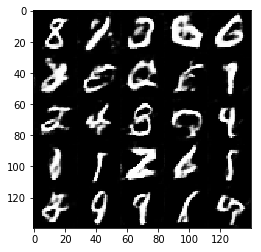

Epoch 2/2... Discriminator Loss: 1.4155 Generator Loss: 0.6016
Epoch 2/2... Discriminator Loss: 1.3522 Generator Loss: 1.2150
Epoch 2/2... Discriminator Loss: 1.3249 Generator Loss: 0.6464
Epoch 2/2... Discriminator Loss: 1.4591 Generator Loss: 1.6266
Epoch 2/2... Discriminator Loss: 1.2112 Generator Loss: 0.7565
Epoch 2/2... Discriminator Loss: 1.4221 Generator Loss: 0.6778
Epoch 2/2... Discriminator Loss: 1.2544 Generator Loss: 0.9956
Epoch 2/2... Discriminator Loss: 1.3563 Generator Loss: 1.4818
Epoch 2/2... Discriminator Loss: 1.3521 Generator Loss: 1.2951
Epoch 2/2... Discriminator Loss: 1.6588 Generator Loss: 1.9624


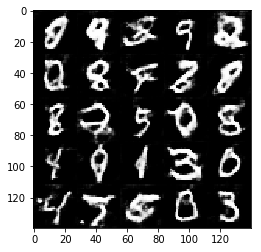

Epoch 2/2... Discriminator Loss: 1.4068 Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 1.2593 Generator Loss: 1.1052
Epoch 2/2... Discriminator Loss: 1.2156 Generator Loss: 0.7961


In [21]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
#print(mnist_dataset.shape)
#print(mnist_dataset.image_mode)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/5... Discriminator Loss: 6.6652 Generator Loss: 0.0028
Epoch 1/5... Discriminator Loss: 6.6145 Generator Loss: 0.0029
Epoch 1/5... Discriminator Loss: 4.7796 Generator Loss: 0.0220
Epoch 1/5... Discriminator Loss: 2.3574 Generator Loss: 0.5255
Epoch 1/5... Discriminator Loss: 4.8487 Generator Loss: 0.0473
Epoch 1/5... Discriminator Loss: 3.9882 Generator Loss: 0.0933
Epoch 1/5... Discriminator Loss: 3.5329 Generator Loss: 0.1218
Epoch 1/5... Discriminator Loss: 3.5843 Generator Loss: 0.1100
Epoch 1/5... Discriminator Loss: 3.4396 Generator Loss: 0.1183
Epoch 1/5... Discriminator Loss: 3.4019 Generator Loss: 0.1013


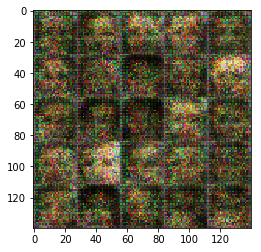

Epoch 1/5... Discriminator Loss: 1.5273 Generator Loss: 2.4623
Epoch 1/5... Discriminator Loss: 3.1787 Generator Loss: 0.1918
Epoch 1/5... Discriminator Loss: 2.7906 Generator Loss: 0.3052
Epoch 1/5... Discriminator Loss: 2.4321 Generator Loss: 0.4976
Epoch 1/5... Discriminator Loss: 1.5816 Generator Loss: 2.7575
Epoch 1/5... Discriminator Loss: 2.6343 Generator Loss: 0.3659
Epoch 1/5... Discriminator Loss: 2.6137 Generator Loss: 0.2935
Epoch 1/5... Discriminator Loss: 2.1705 Generator Loss: 0.4925
Epoch 1/5... Discriminator Loss: 2.5914 Generator Loss: 0.3643
Epoch 1/5... Discriminator Loss: 2.4840 Generator Loss: 0.3635


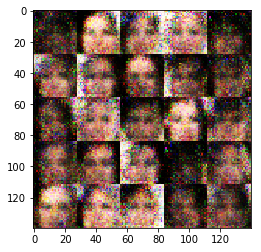

Epoch 1/5... Discriminator Loss: 2.4063 Generator Loss: 0.3690
Epoch 1/5... Discriminator Loss: 2.2948 Generator Loss: 0.4044
Epoch 1/5... Discriminator Loss: 1.9452 Generator Loss: 0.5804
Epoch 1/5... Discriminator Loss: 2.0905 Generator Loss: 0.5122
Epoch 1/5... Discriminator Loss: 2.1753 Generator Loss: 0.4282
Epoch 1/5... Discriminator Loss: 2.0508 Generator Loss: 0.4755
Epoch 1/5... Discriminator Loss: 2.0028 Generator Loss: 0.5028
Epoch 1/5... Discriminator Loss: 1.9531 Generator Loss: 0.5423
Epoch 1/5... Discriminator Loss: 1.8261 Generator Loss: 0.5859
Epoch 1/5... Discriminator Loss: 1.8995 Generator Loss: 0.5544


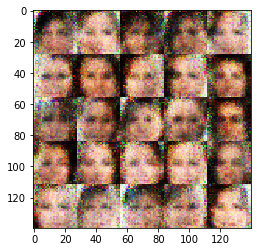

Epoch 1/5... Discriminator Loss: 1.7909 Generator Loss: 0.5666
Epoch 1/5... Discriminator Loss: 1.7742 Generator Loss: 0.6307
Epoch 1/5... Discriminator Loss: 1.7669 Generator Loss: 0.5523
Epoch 1/5... Discriminator Loss: 1.7951 Generator Loss: 0.5770
Epoch 1/5... Discriminator Loss: 1.7654 Generator Loss: 0.6074
Epoch 1/5... Discriminator Loss: 1.7809 Generator Loss: 0.5671
Epoch 1/5... Discriminator Loss: 1.7480 Generator Loss: 0.5629
Epoch 1/5... Discriminator Loss: 1.7111 Generator Loss: 0.6132
Epoch 1/5... Discriminator Loss: 1.6459 Generator Loss: 0.6636
Epoch 1/5... Discriminator Loss: 1.7178 Generator Loss: 0.5926


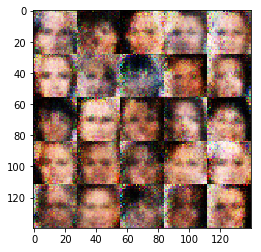

Epoch 1/5... Discriminator Loss: 1.6952 Generator Loss: 0.6084
Epoch 1/5... Discriminator Loss: 1.6692 Generator Loss: 0.6207
Epoch 1/5... Discriminator Loss: 1.6804 Generator Loss: 0.6267
Epoch 1/5... Discriminator Loss: 1.6476 Generator Loss: 0.6481
Epoch 1/5... Discriminator Loss: 1.6952 Generator Loss: 0.6250
Epoch 1/5... Discriminator Loss: 1.5949 Generator Loss: 0.7139
Epoch 1/5... Discriminator Loss: 1.6113 Generator Loss: 0.6908
Epoch 1/5... Discriminator Loss: 1.6348 Generator Loss: 0.6668
Epoch 1/5... Discriminator Loss: 1.6363 Generator Loss: 0.6259
Epoch 1/5... Discriminator Loss: 1.6250 Generator Loss: 0.6317


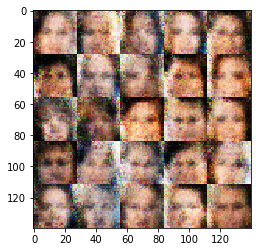

Epoch 1/5... Discriminator Loss: 1.6569 Generator Loss: 0.6308
Epoch 1/5... Discriminator Loss: 1.6297 Generator Loss: 0.6102
Epoch 1/5... Discriminator Loss: 1.5919 Generator Loss: 0.6500
Epoch 1/5... Discriminator Loss: 1.5748 Generator Loss: 0.6951
Epoch 1/5... Discriminator Loss: 1.6116 Generator Loss: 0.6455
Epoch 1/5... Discriminator Loss: 1.5850 Generator Loss: 0.6607
Epoch 1/5... Discriminator Loss: 1.5790 Generator Loss: 0.6866
Epoch 1/5... Discriminator Loss: 1.5916 Generator Loss: 0.6623
Epoch 1/5... Discriminator Loss: 1.5906 Generator Loss: 0.6422
Epoch 1/5... Discriminator Loss: 1.5461 Generator Loss: 0.7200


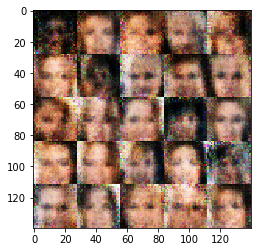

Epoch 1/5... Discriminator Loss: 1.5297 Generator Loss: 0.7278
Epoch 1/5... Discriminator Loss: 1.5793 Generator Loss: 0.6526
Epoch 1/5... Discriminator Loss: 1.5456 Generator Loss: 0.6728
Epoch 1/5... Discriminator Loss: 1.5515 Generator Loss: 0.6718
Epoch 1/5... Discriminator Loss: 1.5731 Generator Loss: 0.6335
Epoch 1/5... Discriminator Loss: 1.5239 Generator Loss: 0.7004
Epoch 1/5... Discriminator Loss: 1.5624 Generator Loss: 0.6721
Epoch 1/5... Discriminator Loss: 1.5668 Generator Loss: 0.6666
Epoch 1/5... Discriminator Loss: 1.5370 Generator Loss: 0.7051
Epoch 1/5... Discriminator Loss: 1.5467 Generator Loss: 0.6746


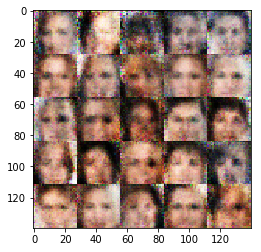

Epoch 1/5... Discriminator Loss: 1.5124 Generator Loss: 0.7388
Epoch 1/5... Discriminator Loss: 1.5444 Generator Loss: 0.7004
Epoch 1/5... Discriminator Loss: 1.5173 Generator Loss: 0.7112
Epoch 1/5... Discriminator Loss: 1.5259 Generator Loss: 0.7070
Epoch 1/5... Discriminator Loss: 1.5246 Generator Loss: 0.7029
Epoch 1/5... Discriminator Loss: 1.5067 Generator Loss: 0.7271
Epoch 1/5... Discriminator Loss: 1.5280 Generator Loss: 0.7190
Epoch 1/5... Discriminator Loss: 1.5088 Generator Loss: 0.7151
Epoch 1/5... Discriminator Loss: 1.5246 Generator Loss: 0.7057
Epoch 1/5... Discriminator Loss: 1.5130 Generator Loss: 0.6984


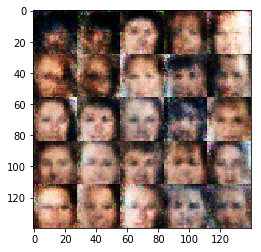

Epoch 1/5... Discriminator Loss: 1.5023 Generator Loss: 0.7273
Epoch 1/5... Discriminator Loss: 1.5051 Generator Loss: 0.6922
Epoch 1/5... Discriminator Loss: 1.5068 Generator Loss: 0.6946
Epoch 1/5... Discriminator Loss: 1.4929 Generator Loss: 0.7459
Epoch 1/5... Discriminator Loss: 1.5112 Generator Loss: 0.7188
Epoch 1/5... Discriminator Loss: 1.4915 Generator Loss: 0.7306
Epoch 1/5... Discriminator Loss: 1.4994 Generator Loss: 0.6959
Epoch 1/5... Discriminator Loss: 1.4958 Generator Loss: 0.7304
Epoch 1/5... Discriminator Loss: 1.5111 Generator Loss: 0.7323
Epoch 1/5... Discriminator Loss: 1.4994 Generator Loss: 0.6971


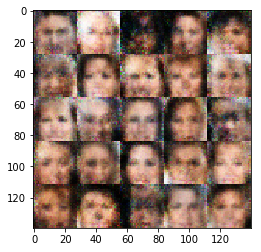

Epoch 1/5... Discriminator Loss: 1.4897 Generator Loss: 0.7351
Epoch 1/5... Discriminator Loss: 1.4989 Generator Loss: 0.7492
Epoch 1/5... Discriminator Loss: 1.4960 Generator Loss: 0.7121
Epoch 1/5... Discriminator Loss: 1.5020 Generator Loss: 0.7058
Epoch 1/5... Discriminator Loss: 1.4915 Generator Loss: 0.7105
Epoch 1/5... Discriminator Loss: 1.4785 Generator Loss: 0.7330
Epoch 1/5... Discriminator Loss: 1.4953 Generator Loss: 0.7056
Epoch 1/5... Discriminator Loss: 1.4825 Generator Loss: 0.6772
Epoch 1/5... Discriminator Loss: 1.5046 Generator Loss: 0.7053
Epoch 1/5... Discriminator Loss: 1.4989 Generator Loss: 0.7099


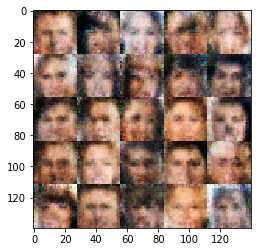

Epoch 1/5... Discriminator Loss: 1.4927 Generator Loss: 0.7014
Epoch 1/5... Discriminator Loss: 1.4812 Generator Loss: 0.7452
Epoch 1/5... Discriminator Loss: 1.4853 Generator Loss: 0.7179
Epoch 1/5... Discriminator Loss: 1.4884 Generator Loss: 0.7194
Epoch 1/5... Discriminator Loss: 1.4841 Generator Loss: 0.6919
Epoch 1/5... Discriminator Loss: 1.4671 Generator Loss: 0.7534
Epoch 1/5... Discriminator Loss: 1.4779 Generator Loss: 0.7073
Epoch 1/5... Discriminator Loss: 1.4821 Generator Loss: 0.6920
Epoch 1/5... Discriminator Loss: 1.4783 Generator Loss: 0.7219
Epoch 1/5... Discriminator Loss: 1.4801 Generator Loss: 0.7223


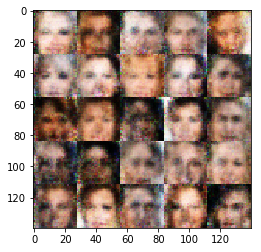

Epoch 1/5... Discriminator Loss: 1.4780 Generator Loss: 0.7349
Epoch 1/5... Discriminator Loss: 1.4837 Generator Loss: 0.7354
Epoch 1/5... Discriminator Loss: 1.4654 Generator Loss: 0.7006
Epoch 1/5... Discriminator Loss: 1.4763 Generator Loss: 0.7120
Epoch 1/5... Discriminator Loss: 1.4848 Generator Loss: 0.7039
Epoch 1/5... Discriminator Loss: 1.4823 Generator Loss: 0.7177
Epoch 1/5... Discriminator Loss: 1.4724 Generator Loss: 0.7180
Epoch 1/5... Discriminator Loss: 1.4659 Generator Loss: 0.7523
Epoch 1/5... Discriminator Loss: 1.4600 Generator Loss: 0.7887
Epoch 1/5... Discriminator Loss: 1.4659 Generator Loss: 0.7381


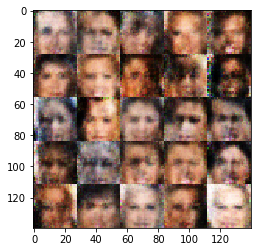

Epoch 1/5... Discriminator Loss: 1.4691 Generator Loss: 0.7361
Epoch 1/5... Discriminator Loss: 1.4700 Generator Loss: 0.7117
Epoch 1/5... Discriminator Loss: 1.4699 Generator Loss: 0.7339
Epoch 1/5... Discriminator Loss: 1.4645 Generator Loss: 0.7301
Epoch 1/5... Discriminator Loss: 1.4656 Generator Loss: 0.7553
Epoch 1/5... Discriminator Loss: 1.4476 Generator Loss: 0.7862
Epoch 1/5... Discriminator Loss: 1.4674 Generator Loss: 0.7180
Epoch 1/5... Discriminator Loss: 1.4712 Generator Loss: 0.7489
Epoch 1/5... Discriminator Loss: 1.4597 Generator Loss: 0.7695
Epoch 1/5... Discriminator Loss: 1.4609 Generator Loss: 0.7319


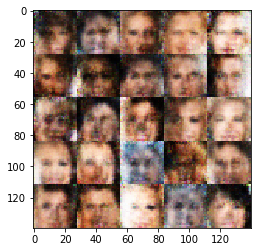

Epoch 1/5... Discriminator Loss: 1.4562 Generator Loss: 0.7162
Epoch 1/5... Discriminator Loss: 1.4571 Generator Loss: 0.7568


KeyboardInterrupt: 

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
#print(celeba_dataset.shape)
#print(celeba_dataset.image_mode)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.